# **MRMS/CCRFCD** rain-gauge data analysis
---

- Time Period: [2021.01.01-2025.07.25]
- **`TODO`**: describe data-collection methodology in detail
- **`TODO`**: explain format of master-dataframe
- **`TODO`**: upload compressed master-df
- **`TODO`**: test notebook in Google Colab

### 0. Packages, imports, and magic constants

In [ ]:
# !pip install numpy pandas matplotlib scikit-learn -q
# unzip mrms/ccrfcd aligned data `.csv` file
!gzip -d "./data/events/2021-01-01_2025-07-25_all_events.csv" -k

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from datetime import datetime


ALL_EVENTS_DF = "./data/events/2021-01-01_2025-07-25_all_events.csv"

### 1. Exploring the dataset

We have already built a tabular dataset of MRMS and CCRFCD rain gauge 1H QPE values for days between 01-01-21 and 07-25-25 during which a **meaningful amount** of rain fell in the Las Vegas valley area. Below, we load raw data from memory into a `pandas.DataFrame` object.

> More details can be found in the `readme.md` in this repo.

In [ ]:
df = pd.read_csv(ALL_EVENTS_DF)

# filter out extreme values (i.e., <= 0.001 and >= 0.999 percentile)
# occasional outlier rain-gauge values appear in the CCRFCD database; CCRFCD does not perform any QC
mask = (df["delta_qpe"] > df["delta_qpe"].quantile(0.001)) & (
    df["delta_qpe"] < df["delta_qpe"].quantile(0.999)
)
df = df.loc[mask]

# drop some unused columns
df = df.drop(["cum_gauge_qpe", "cum_mrms_qpe"], axis=1)

# convert start/end times to datetime objs
df["start_time"] = pd.to_datetime(df["start_time"])
df["event_time"] = pd.to_datetime(df["end_time"])

df.head()

,start_time,end_time,station_id,lat,lon,gauge_qpe,mrms_qpe,delta_qpe
0,2021-01-23 23:00:00,2021-01-24 00:00:00,4709,35.925000,244.883000,0.00,0.003937,-0.003937
1,2021-01-23 23:00:00,2021-01-24 00:00:00,4564,36.028250,244.996361,0.04,0.000000,0.040000
2,2021-01-23 23:00:00,2021-01-24 00:00:00,4779,36.021861,245.041250,0.04,0.000000,0.040000
3,2021-01-23 23:00:00,2021-01-24 00:00:00,4984,35.729250,244.811972,0.00,0.011811,-0.011811
4,2021-01-23 23:00:00,2021-01-24 00:00:00,4724,35.939417,244.922250,0.00,0.015748,-0.015748


Let's break down each of these columns:
- `start_time`: (**UTC**)
- `end_time`: (**UTC**)
- `station_id`: the CCRFCD rain-gauge's ID number
- `lat`/`lon`: location of the rain-gauge
- `gauge_qpe`: **(inches)** cummulative rainfall recorded by gauge between `start_time`/`end_time`
- `mrms_qpe`: **(inches)** cummulative rainfall recorded by MRMS radar-only product between `start_time`/`end_time` at `lat`/`lon`
    - Value for *the **nearest** MRMS grid-cell* to `lat`/`lon`
- `delta_qpe`: `gauge_qpe` - `mrms_qpe`

In [38]:
print(f"# Data points: {len(df)}")
print(f"# Unique gauges: {len(set(df['station_id']))}")

# Data points: 2337407
# Unique gauges: 223


#### 1.1. Distribution of unique datetimes

In [43]:
# t: unique timesteps in set of all timesteps {1, ..., n}
unique_dts = {
    datetime.strptime(s, "%Y-%m-%d %H:%M:%S")
    for s in set(df['start_time'])
}

print(f"# Unique timesteps: {len(unique_dts)}")

# Unique timesteps: 82376


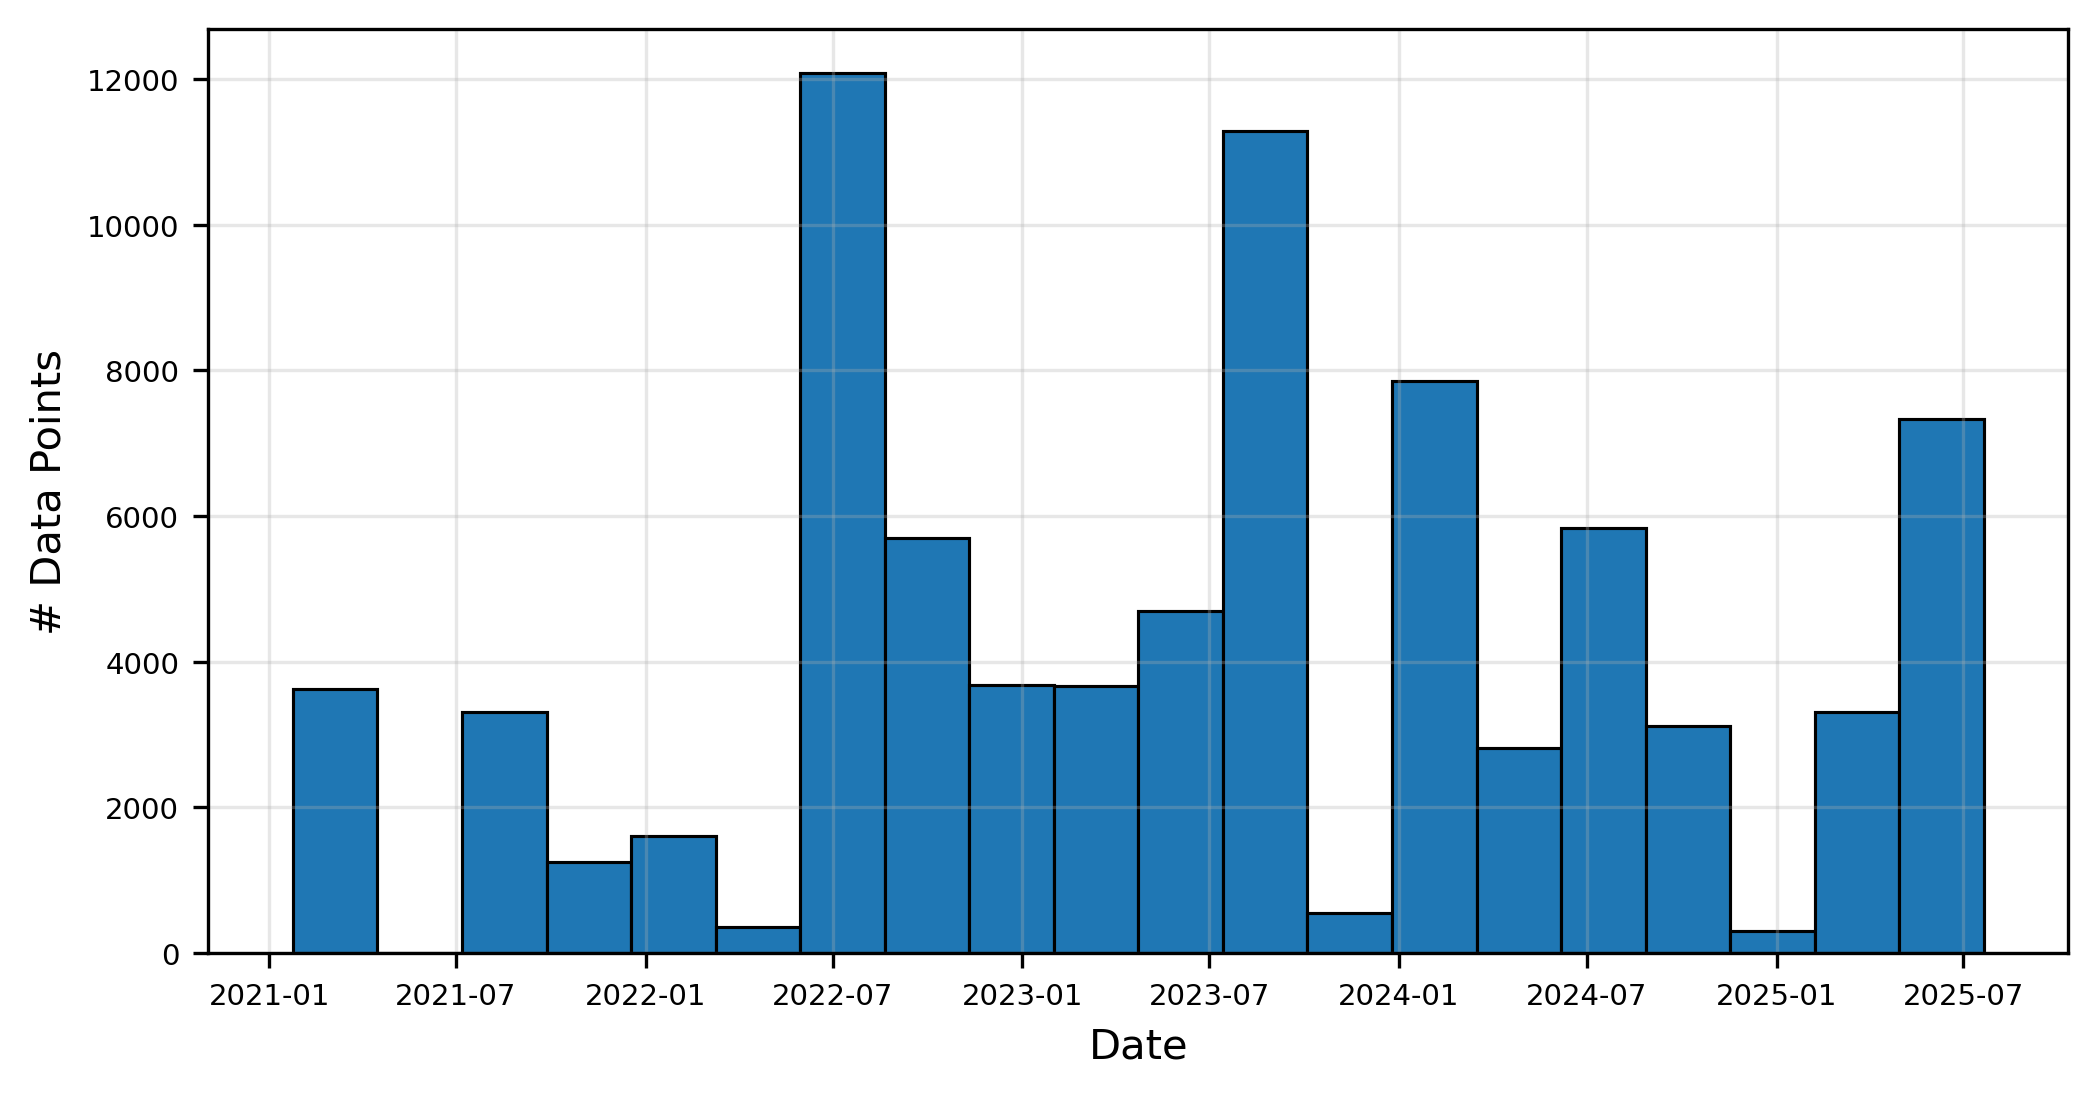

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=300)

ax.hist(unique_dts, edgecolor='black', linewidth=0.75, bins=20)
ax.grid(alpha=0.3)

plt.xlabel("Date")
plt.xticks(fontsize=7)
plt.ylabel("# Data Points")
plt.yticks(fontsize=7)
plt.show()

#### 1.2. Distribution of total `mrms_qpe` by month

- Below we sum all the MRMS 1H-QPE values at each rain gauge.

In [ ]:
months = df["start_time"].dt.month
years  = df['start_time'].dt.year

all_values = []
for i in range(1, 13):
    month_arr = []
    for j in range(2021, 2025 + 1):
        mask       = months.between(i, i) & years.between(j, j)
        delta_qpes = df.loc[mask, "mrms_qpe"].tolist()
        total_qpe  = float(np.array(delta_qpes).sum())
        if total_qpe > 0.0:
            month_arr.append(total_qpe)
    all_values.append(month_arr)

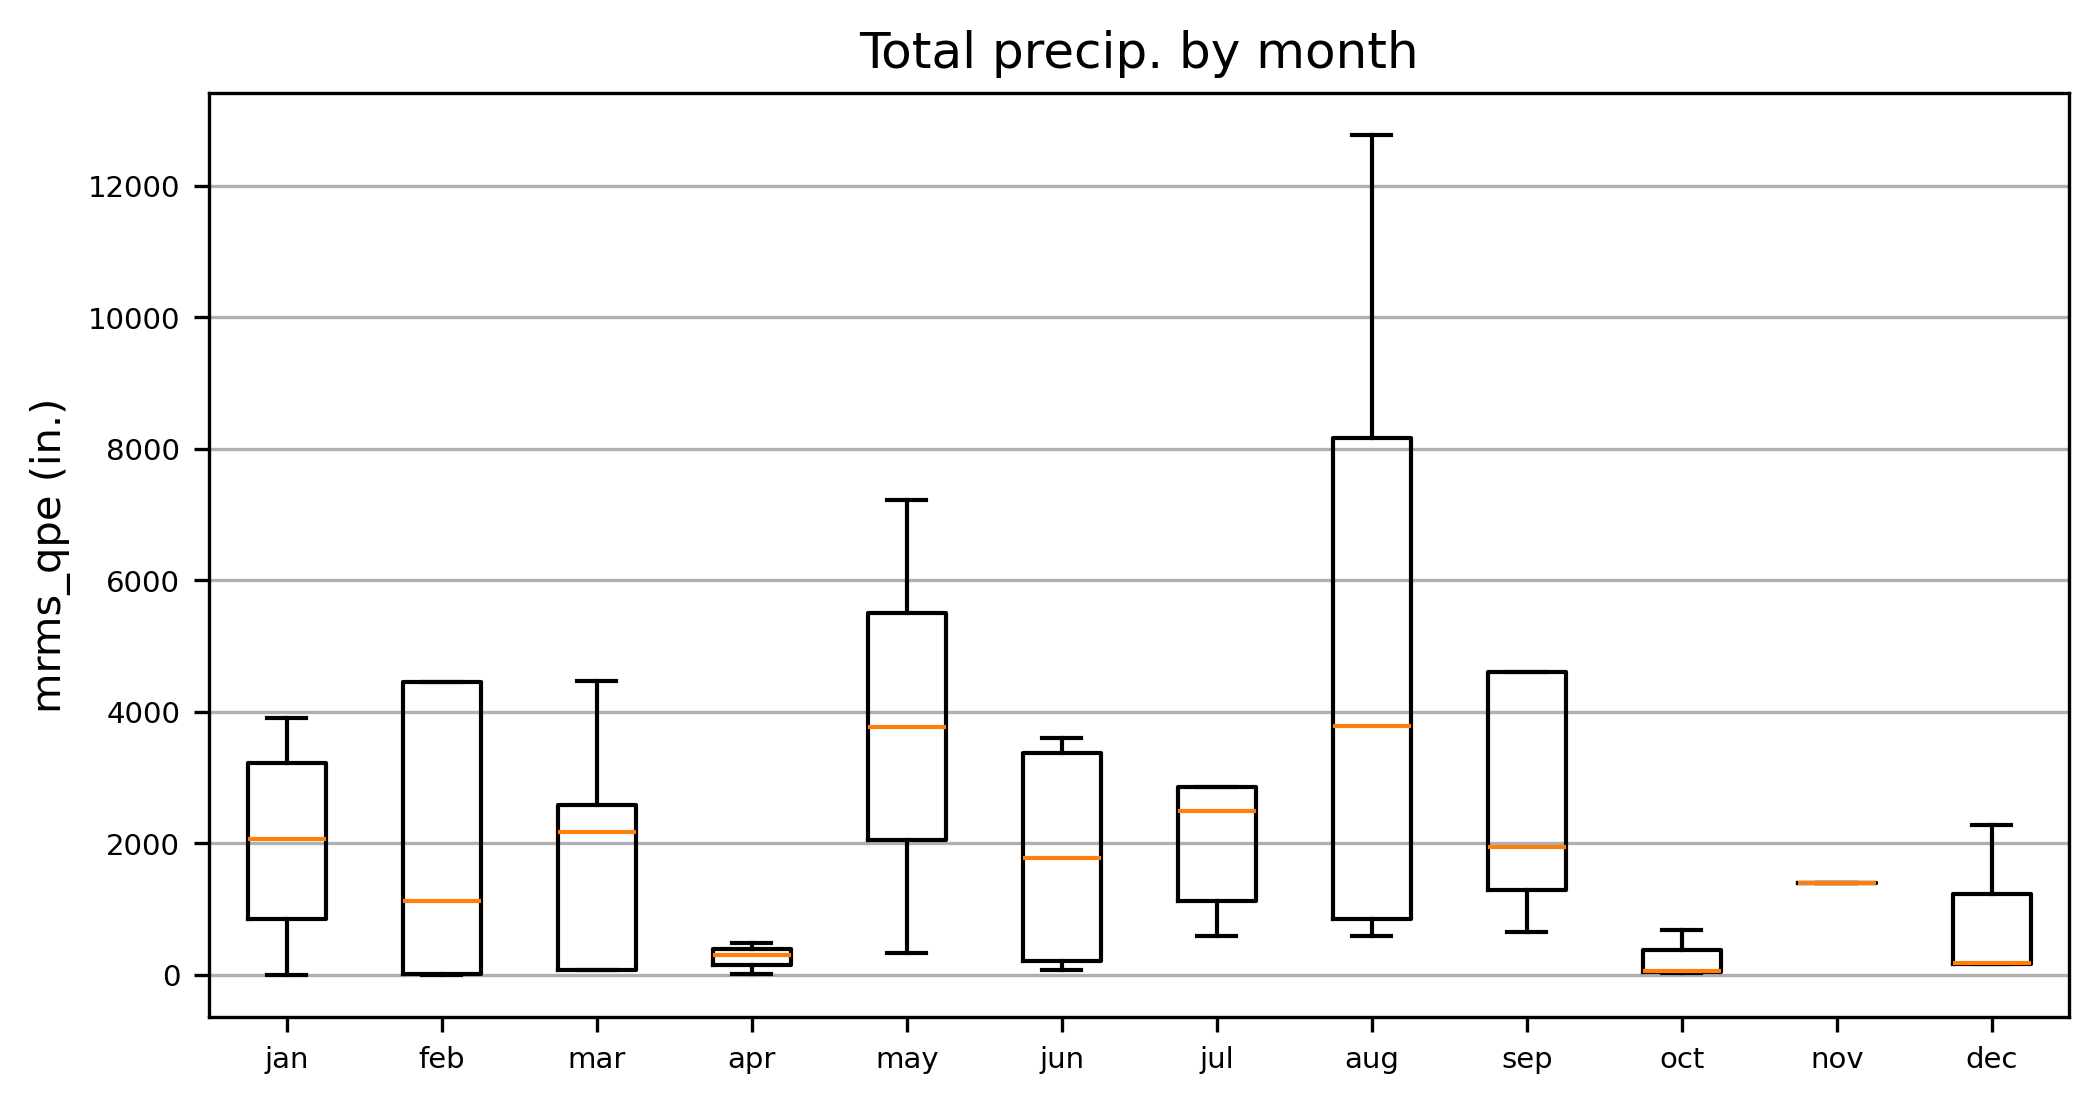

In [47]:
fig, axs = plt.subplots(figsize=(8, 4), dpi=300)
axs.boxplot(
    all_values,
    notch=False,
    showfliers=False,
    )

axs.yaxis.grid(True)
axs.set_xticks([y + 1 for y in range(12)],
                  labels=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])

plt.title("Total precip. by month")
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.ylabel("mrms_qpe (in.)")
plt.show()

### 2. Per-Event Analysis

#### 2.1. Constructing Synthetic Rainfall "Events"

- Currently, our dataset lacks any meaningful markers to segment moments in time into distinct rainfall "events". Below, we create synthetic "events" to analyize temporal effects on rain gauge bias.

In [48]:
# sum of all MRMS values for all gauges at each unique timestep
grouped_df   = df[['start_time', 'mrms_qpe']].groupby('start_time').sum().copy()
cum_mrms_qpe = grouped_df['mrms_qpe']
series       = np.asarray(list(cum_mrms_qpe))

# lower bound of total precip at a timestep
# we denote this to be a "dry" period
p50          = np.percentile(series, 50)
print(f"50th percentile MRMS 1H-QPE: {p50:0.4f} in.")

50th percentile MRMS 1H-QPE: 0.1457 in.


In [49]:
def segment_rainfall_events(
        precip_array: np.ndarray, 
        interval_minutes=2, 
        wet_period_mins=15, 
        dry_period_mins=15,
        rain_threshold=p50,
    ) -> pd.DataFrame:
    """
    Segment a 1D array of total precip. values into 
        distinct events (i.e., [`start_time`, `end_time`]).

    Params
    - `wet_period_mins`
        - Number of minutes that must elapse where (rain_falling > rain_threshold) in order to begin a rainfall event
    - `dry_period_mins`
        - Number of minutes that must elapse where (rain_falling < rain_threshold) to label a period of time as "dry"

    Returns:
    ---
        pd.DataFrame: Columns include 'precipitation' and 'is_event' (bool).
    """

    # mask: rain is falling
    precip_series      = pd.Series(precip_array)
    is_rain: pd.Series = (precip_series > rain_threshold).astype(int)

    # our data is recorded with 2 minute timesteps
    # here, calculate the number of steps-per-interval
    wet_period_intervals = wet_period_mins // interval_minutes
    dry_period_intervals = dry_period_mins // interval_minutes
    
    rolling_wet     = is_rain.rolling(window=wet_period_intervals, min_periods=wet_period_intervals).sum()
    valid_wet_start = (rolling_wet == wet_period_intervals)
    rolling_dry     = is_rain.rolling(window=dry_period_intervals, min_periods=dry_period_intervals).sum()
    valid_dry_end   = (rolling_dry == 0)

    is_event = np.zeros_like(is_rain, dtype=bool)

    in_event = False
    start_idx = 0

    for i in range(len(is_rain)):
        if not in_event:

            # wait until a valid wet period starts
            if valid_wet_start.iloc[i]:
                in_event = True
                
                # start of rain
                start_idx = i - wet_period_intervals + 1 
        else:
            
            # if inside an event, check for a valid dry period to end the event
            if valid_dry_end.iloc[i]:
                end_idx = i - dry_period_intervals + 1
                is_event[start_idx:end_idx] = True
                in_event = False

    if in_event:
        is_event[start_idx:] = True

    return pd.DataFrame({
        'precipitation': precip_series,
        'is_event': is_event
    })

In [50]:
# segment total precip array into "events"
rainfall_events = segment_rainfall_events(series)

event_ids = []
curr_id   = -1
in_event  = False

for is_event in rainfall_events['is_event'].values:
    if is_event:
        if not in_event:
            curr_id += 1
            in_event = True
        event_ids.append(curr_id)
    else:
        in_event = False
        event_ids.append(np.nan)

grouped_df['event_id'] = event_ids
event_ids_mapped       = dict(zip(grouped_df.index, grouped_df['event_id'].values))

In [51]:
event_ids      = [event_ids_mapped[k] for k in list(df['start_time'])]
df['event_id'] = event_ids
df_rain_events = df.loc[df['event_id'] > 0.0]

print(f"# Data points for rain events: {len(df_rain_events)}")
print(f"# Unique events: {len(set(df_rain_events['event_id']))}")

# ~2.2M data points from rainfall "events"
df_rain_events.head()

# Data points for rain events: 2210621
# Unique events: 297


,start_time,end_time,station_id,lat,lon,gauge_qpe,mrms_qpe,delta_qpe,event_time,event_id
1666,2021-01-24 02:36:00,2021-01-24 03:36:00,4914,35.850389,244.552694,0.0,0.003937,-0.003937,2021-01-24 03:36:00,1.0
1667,2021-01-24 02:36:00,2021-01-24 03:36:00,4034,36.343167,244.833333,0.0,0.007874,-0.007874,2021-01-24 03:36:00,1.0
1668,2021-01-24 02:36:00,2021-01-24 03:36:00,4609,35.997778,244.714444,0.0,0.003937,-0.003937,2021-01-24 03:36:00,1.0
1669,2021-01-24 02:36:00,2021-01-24 03:36:00,4334,36.058000,244.677639,0.0,0.007874,-0.007874,2021-01-24 03:36:00,1.0
1670,2021-01-24 02:36:00,2021-01-24 03:36:00,8,35.961000,245.372360,0.0,0.027559,-0.027559,2021-01-24 03:36:00,1.0


In [52]:
df_rain_events = df_rain_events.loc[df_rain_events['gauge_qpe'] > 0.50]

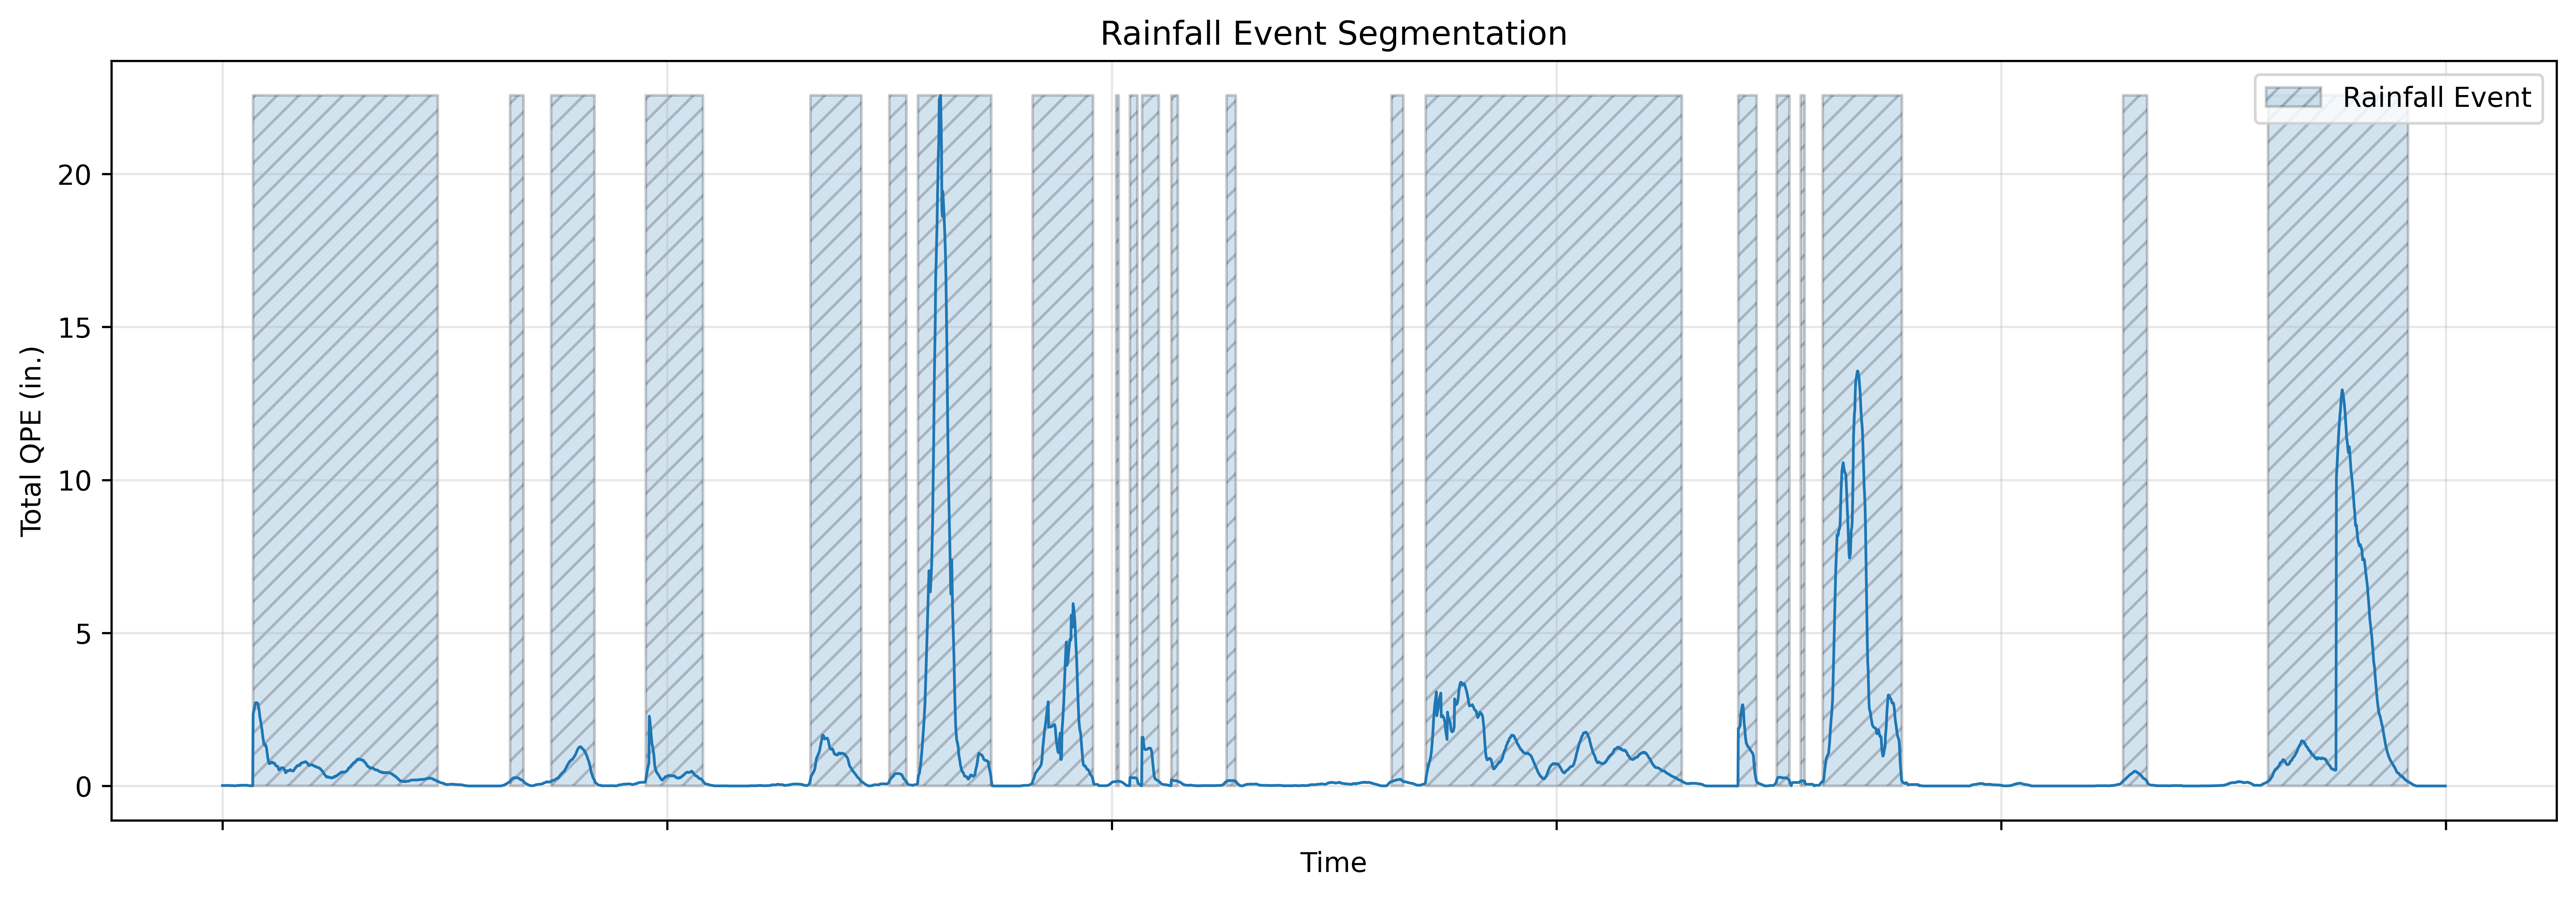

In [53]:
rainfall_events_subset = rainfall_events[3000:8000]

fig, ax = plt.subplots(figsize=(16, 5), dpi=600)

x = np.arange(0, len(rainfall_events_subset))
y = rainfall_events_subset['precipitation']

ax.fill_between(
    x, 
    0, 
    y.max(), 
    where=rainfall_events_subset['is_event'] > 0.0, 
    hatch='///',
    label="Rainfall Event",
    edgecolor="black",
    alpha=0.2,
    )
ax.plot(x, y, linewidth=1.0, scaley=True)

ax.set_ylabel("Total QPE (in.)")
ax.set_xlabel("Time")
ax.set_xticklabels([])
ax.grid(alpha=0.3)
ax.legend(loc="upper right")

plt.title("Rainfall Event Segmentation")
plt.show()

#### 2.2. Rain-Event Statistics

In [54]:
# create a list of `start_time` for each unique rain event
unique_events = df_rain_events.drop_duplicates(subset="event_id")
dts           = pd.to_datetime(unique_events["start_time"]).tolist()

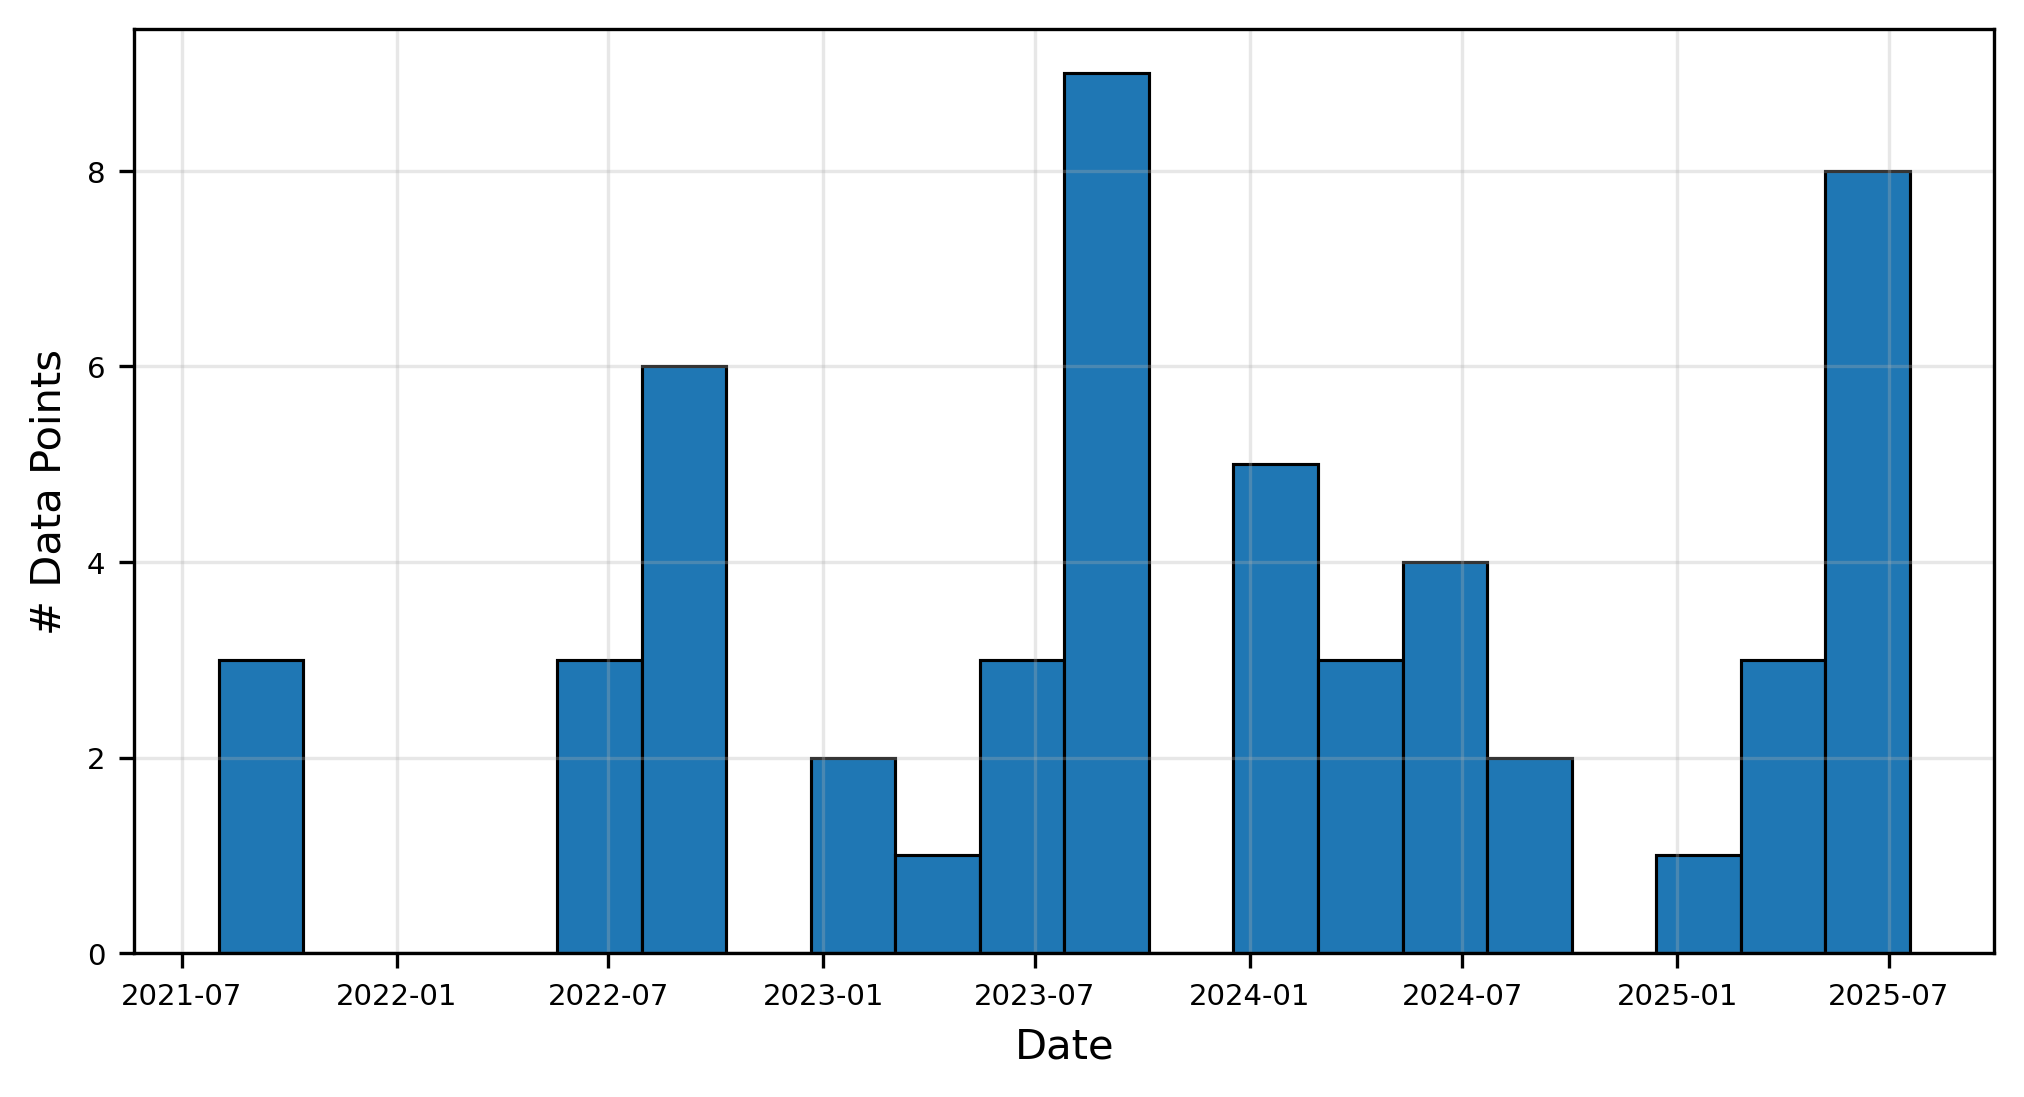

In [55]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=300)

ax.hist(dts, edgecolor='black', linewidth=0.75, bins=20)
ax.grid(alpha=0.3)

plt.xlabel("Date")
plt.xticks(fontsize=7)
plt.ylabel("# Data Points")
plt.yticks(fontsize=7)
plt.show()

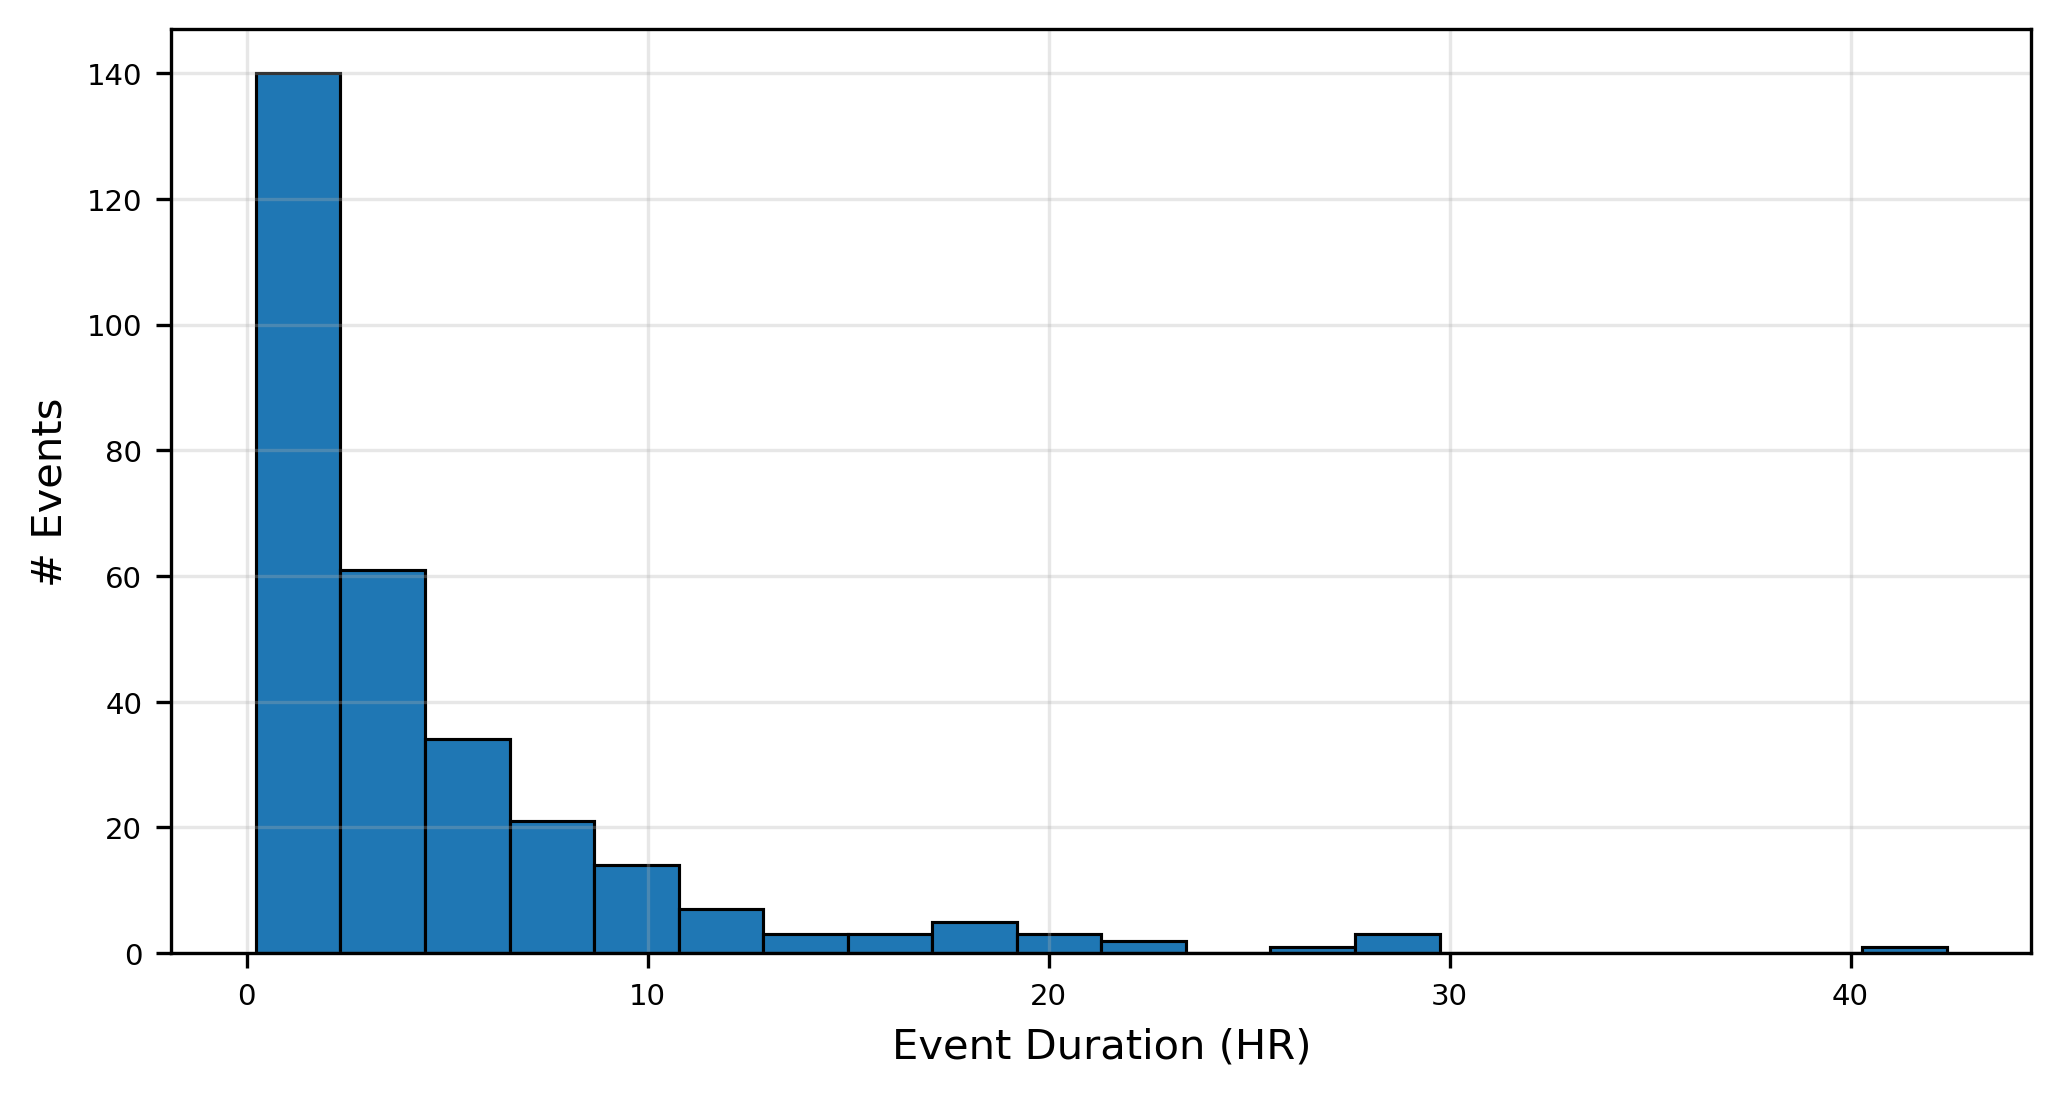

In [56]:
# a bit of a hack to grab the duration of each event
durations = grouped_df.groupby('event_id').count()['mrms_qpe']

# 2 min. buckets -> hrs
hr_durations = durations * (1/30)

fig, ax = plt.subplots(figsize=(8, 4), dpi=300)

ax.hist(hr_durations, edgecolor='black', linewidth=0.75, bins=20)
ax.grid(alpha=0.3)

plt.xlabel("Event Duration (HR)")
plt.xticks(fontsize=7)
plt.ylabel("# Events")
plt.yticks(fontsize=7)
plt.show()

In [57]:
cols = ['start_time', 'event_id', 'mrms_qpe', 'gauge_qpe']
df   = df_rain_events[cols]
df   = (
    df.groupby(['event_id', 'start_time'], as_index=False)
      .sum(numeric_only=True)
      .sort_values(['event_id', 'start_time'])
)

df['t_idx'] = df.groupby('event_id').cumcount()

mrms_mat   = df.pivot(index='event_id', columns='t_idx', values='mrms_qpe')
gauge_mat  = df.pivot(index='event_id', columns='t_idx', values='gauge_qpe')

mrms_means   = np.nanmean(mrms_mat.to_numpy(),  axis=0)
gauge_means  = np.nanmean(gauge_mat.to_numpy(), axis=0)

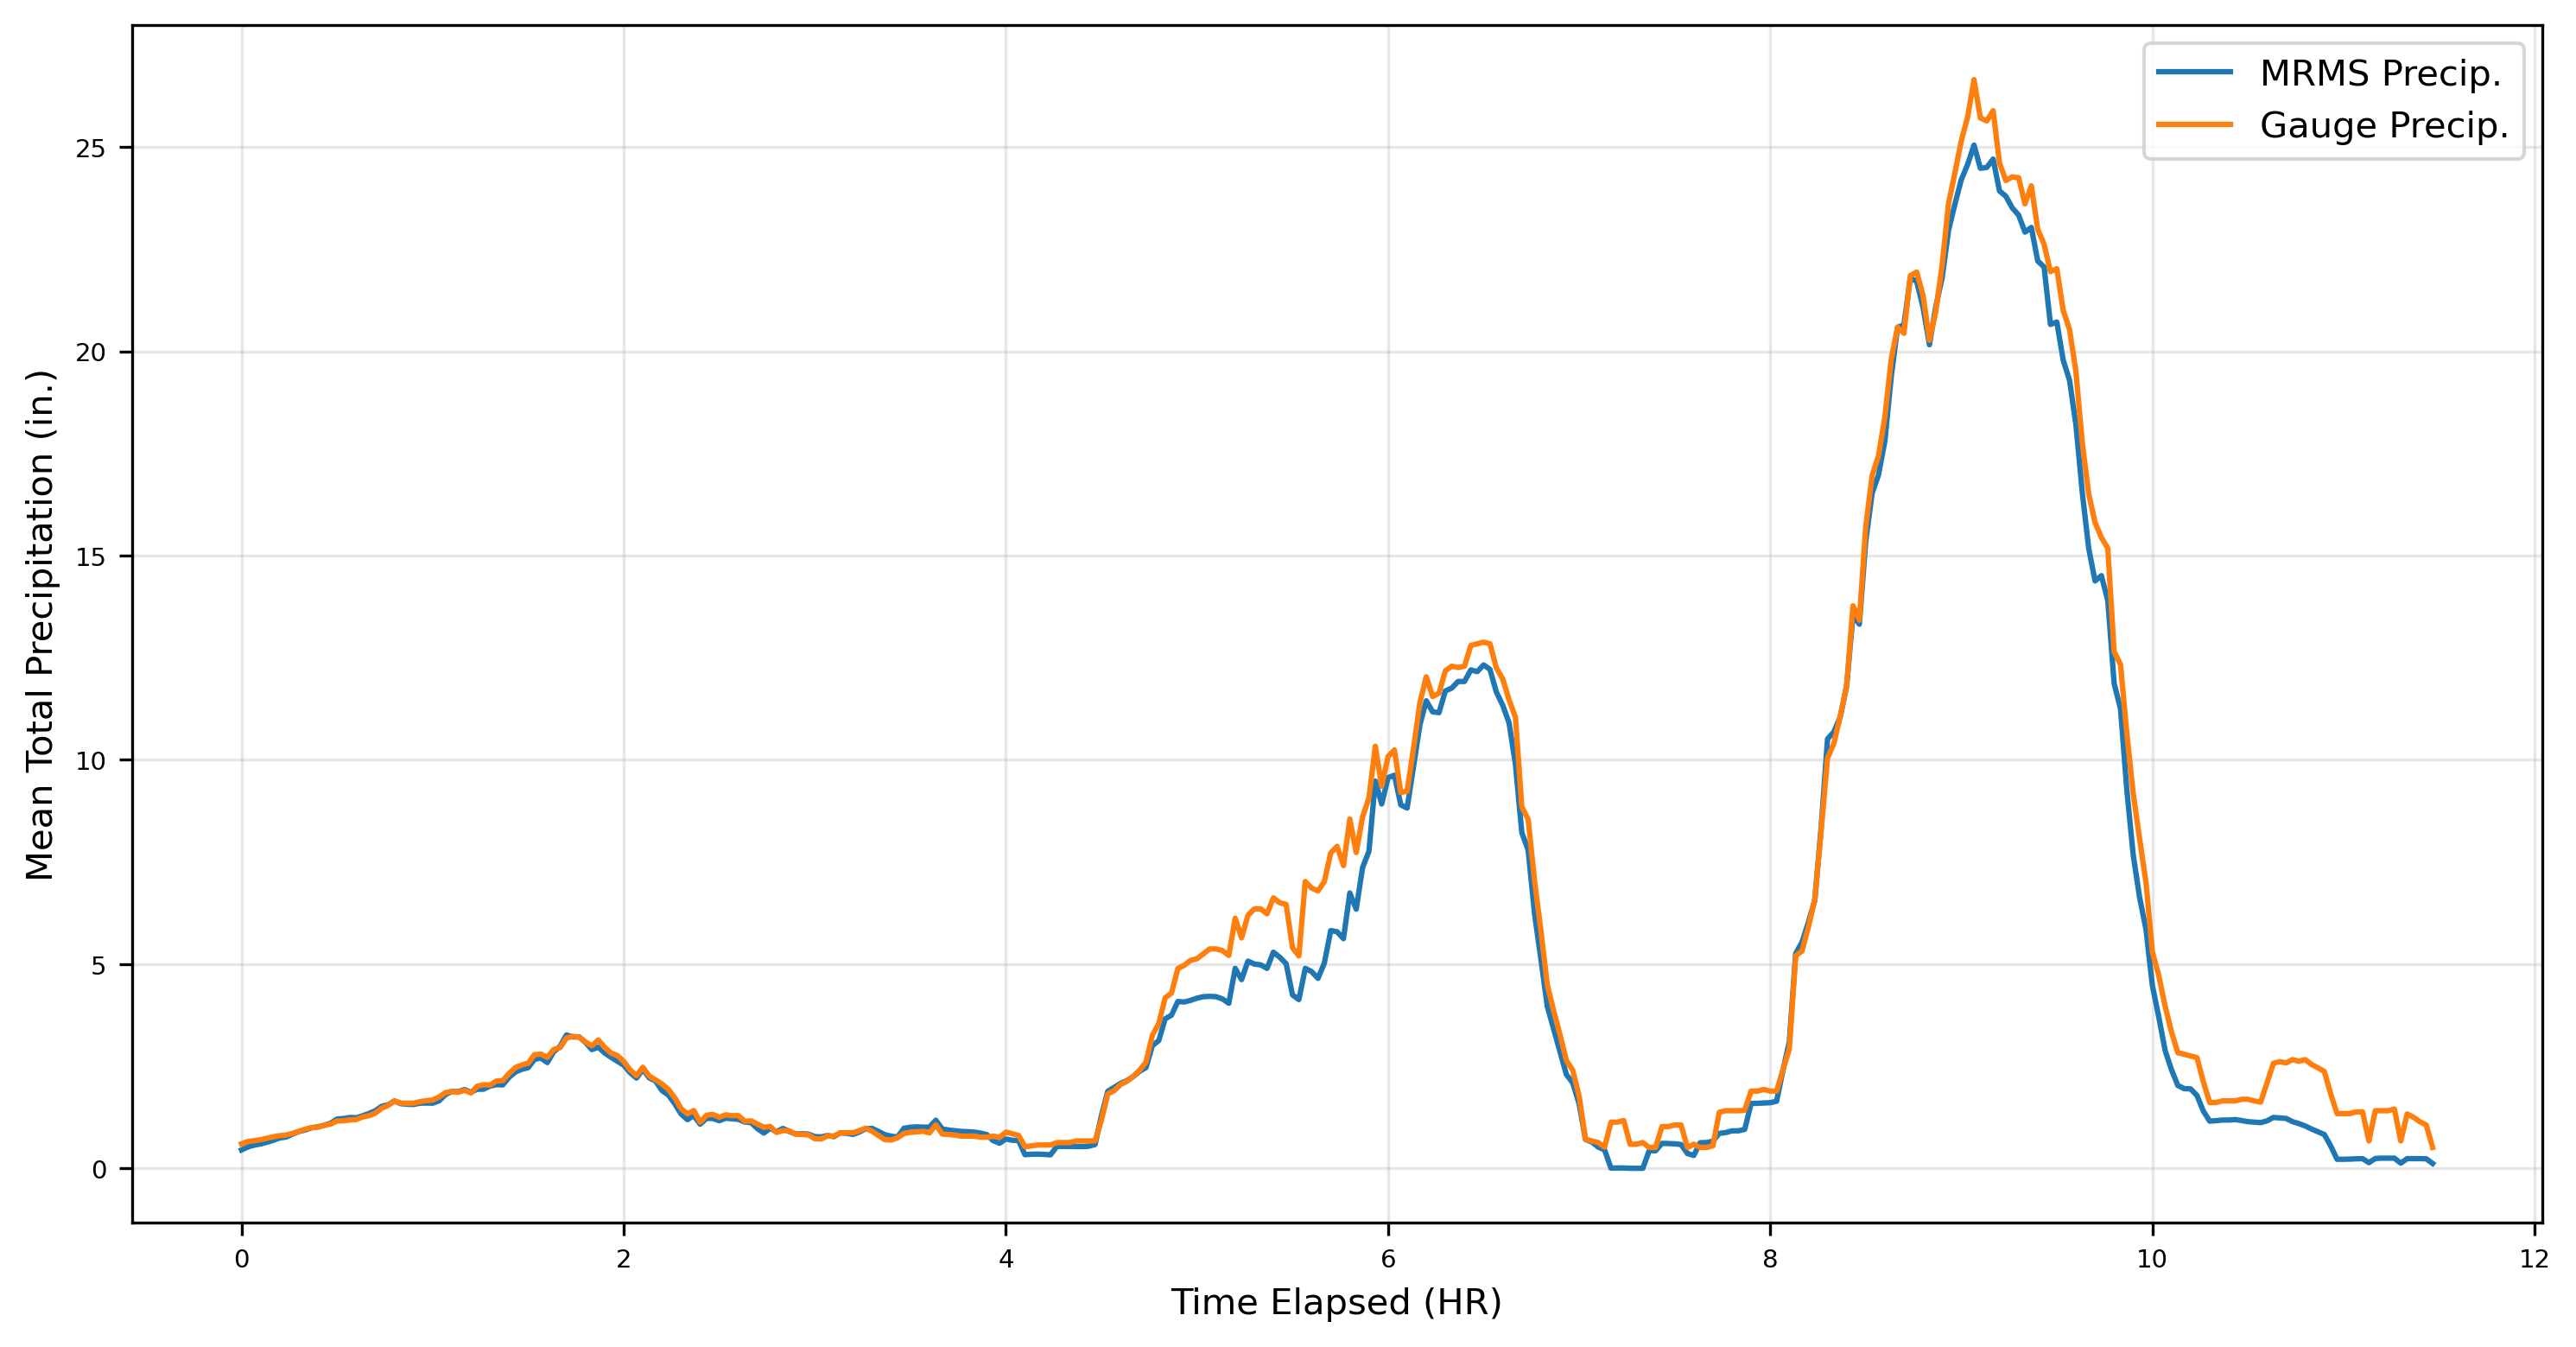

In [58]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

indices = [i/30 for i in range(len(mrms_means))]

# # plot all MRMS timeseries
# for i in range(mrms_mat.values.shape[0]):
#     arr = mrms_mat.values[i, :]
#     ax.plot(indices, arr, alpha=0.1)

ax.plot(indices, mrms_means, label="MRMS Precip.")
ax.plot(indices, gauge_means, label="Gauge Precip.")
ax.grid(alpha=0.3)

plt.xlabel("Time Elapsed (HR)")
plt.xticks(fontsize=7)
plt.ylabel("Mean Total Precipitation (in.)")
plt.yticks(fontsize=7)

plt.legend()
plt.show()

### 3. Enviornmental Analysis

In [59]:
# TODO: add enviornmental params from soundings/ASOS

import json
import sounderpy as spy


# data = spy.get_obs_data("VEF", 2021, 1, 23, 0)
test_sounding = "./data/events/2021-01-23 00:00:00/2021-01-23 00:00:00_VEF_0Z_sounding.json"

with open(test_sounding, 'r') as f:
    data = json.load(f)


## ---------------------------------- SOUNDERPY ----------------------------------- ##
##          Vertical Profile Data Retrieval and Analysis Tool For Python            ##
##                      v3.0.8 | Jan 2025 | (C) Kyle J Gillett                      ##
##                 Docs: https://kylejgillett.github.io/sounderpy/                  ##
## --------------------- THANK YOU FOR USING THIS PACKAGE! ------------------------ ##



In [60]:
import pandas as pd
import numpy as np
import math


# -> np.ndarray
p  = np.array(data['p']['value'])
T  = np.array(data['T']['value'])
Td = np.array(data['Td']['value'])

In [61]:
import metpy.calc as mpcalc
from metpy.units import units
from metpy.interpolate import interpolate_1d


def sounding_metrics(p_hpa: np.ndarray, t_c: np.ndarray, td_c: np.ndarray) -> dict:
    """
    Compute key sounding diagnostics:
        • 850 hPa Td
        • 700 hPa Td
        • 750 hPa T, Td, θe
        • Column precipitable water

    Parameters
    ----------
    p_hpa, t_c, td_c : 1-D array-like
        Pressure (hPa), temperature (°C) and dew-point (°C) profiles,
        ordered from surface → top.

    Returns
    -------
    dict of scalar floats
    """

    p      = p_hpa * units.hPa
    T      = t_c   * units.degC
    Td     = td_c  * units.degC

    td_850 = interpolate_1d(850 * units.hPa, p, Td).to('degC')
    td_700 = interpolate_1d(700 * units.hPa, p, Td).to('degC')
    T_750  = interpolate_1d(750 * units.hPa, p, T ).to('degC')
    Td_750 = interpolate_1d(750 * units.hPa, p, Td).to('degC')

    pwat = mpcalc.precipitable_water(p, Td).to('millimeter')
    
    theta_e_750 = mpcalc.equivalent_potential_temperature(
        750 * units.hPa,
        T_750.to('kelvin'),
        Td_750.to('kelvin')
    ).to('kelvin')

    return {
        'Td_850_C'      : td_850.m[0],
        'Td_700_C'      : td_700.m[0],
        'PWAT_mm'       : pwat.m,
        'theta_e_750_K' : theta_e_750.m[0],
    }


metrics = sounding_metrics(p, T, Td)
print(f"850 hPa dew-point : {metrics['Td_850_C']:.1f} °C")
print(f"700 hPa dew-point : {metrics['Td_700_C']:.1f} °C")
print(f"PWAT (column)     : {metrics['PWAT_mm']:.1f} mm "
      f"(~{metrics['PWAT_mm']*0.03937:.2f} in)")
print(f"750 hPa θe        : {metrics['theta_e_750_K']:.0f} K "
      f"(~{metrics['theta_e_750_K']-273.15:.1f} °C)")

850 hPa dew-point : -0.4 °C
700 hPa dew-point : -12.9 °C
PWAT (column)     : 11.8 mm (~0.46 in)
750 hPa θe        : 306 K (~32.7 °C)


In [62]:
from tqdm import tqdm
from glob import glob

# 1. load all soundings into cache
fps = glob("./data/events/*/*_sounding.json")
cache = {}
dt_objs = []

for fp in tqdm(fps):

    dts = fp.split("/")[4].strip("_sounding.json")
    year = int(dts[0:4])
    month = int(dts[5:7])
    day = int(dts[8:10])
    hour = int(dts.split("_")[-1][:-1])
    dt = datetime(year, month, day, hour)
    dt_objs.append(dt)

    with open(fp, 'r') as f:
        cache[str(dt)] = json.load(f)

100%|██████████| 463/463 [00:00<00:00, 7147.00it/s]


In [63]:
# from pprint import pprint
# from datetime import timedelta


# for dt in tqdm(df_rain_events['start_time']):
    
#     time_diffs = {}
    
#     for dt_2 in dt_objs:
        
#         # sounding - row_time
#         # -: sounding occured before row
#         # +: sounding occured after row
#         diff: timedelta = dt_2 - dt
#         time_diffs[int(diff.total_seconds())] = dt_2
    
#     time_diffs_arr = np.array(list(time_diffs.keys()))

#     # get the two smallest differences
#     sorted_diffs = sorted(time_diffs_arr[time_diffs_arr < 0.0])[-2: ]
    
#     closest_sounding_dt        = time_diffs[int(sorted_diffs[1])]
#     second_closest_sounding_dt = time_diffs[int(sorted_diffs[0])]
    
#     # ...
#     closest_sounding        = cache[str(closest_sounding_dt)]

#     p  = np.array(closest_sounding['p']['value'])
#     T  = np.array(closest_sounding['T']['value'])
#     Td = np.array(closest_sounding['Td']['value'])

#     metrics = sounding_metrics(p, T, Td)

#     eight_five_zero_dps_6z.append(float(metrics['Td_850_C']))
#     seven_zero_zero_dps_6z.append(float(metrics['Td_700_C']))
#     pwat_6z.append(float(metrics['PWAT_mm']))
#     seven_five_zero_te_6z.append(float(metrics['theta_e_750_K']))
    
#     # ...
#     second_closest_sounding = cache[str(second_closest_sounding_dt)]
    
#     p  = np.array(second_closest_sounding['p']['value'])
#     T  = np.array(second_closest_sounding['T']['value'])
#     Td = np.array(second_closest_sounding['Td']['value'])

#     metrics = sounding_metrics(p, T, Td)

#     eight_five_zero_dps_12z.append(float(metrics['Td_850_C']))
#     seven_zero_zero_dps_12z.append(float(metrics['Td_700_C']))
#     pwat_12z.append(float(metrics['PWAT_mm']))
#     seven_five_zero_te_12z.append(float(metrics['theta_e_750_K']))


In [64]:
eight_five_zero_dps_6z  = []
eight_five_zero_dps_12z = []
seven_zero_zero_dps_6z  = []
seven_zero_zero_dps_12z = []
pwat_6z                 = []
pwat_12z                = []
seven_five_zero_te_6z   = []
seven_five_zero_te_12z  = []


import numpy as np
from bisect import bisect_left 

# Sounding times in **ascending** order
sound_dts         = sorted(dt_objs)                       # list[datetime]
sound_ts          = np.fromiter((d.timestamp() for d in sound_dts),
                                dtype=np.float64)         # NumPy array
metrics_cache     = {}            # {str(dt): dict}   avoid recomputing metrics

# ---------------------------------------------------------------------------
# 1)  Main loop — O(N × log M) instead of O(N × M)
# ---------------------------------------------------------------------------
for dt in tqdm(df_rain_events['start_time']):
    ts = dt.timestamp()

    # index of the first sounding **after** the event time
    idx = np.searchsorted(sound_ts, ts, side='left')

    # Guard-rail: need two prior soundings
    if idx < 2:
        # Not enough history — skip or handle as you prefer
        continue

    # The two most recent *prior* soundings
    closest_sounding_dt        = sound_dts[idx - 1]   # Δt is smallest (most recent)
    second_closest_sounding_dt = sound_dts[idx - 2]

    # ------------------------------------------------------------------
    # 1a)  Metrics for the closest sounding (6 Z) — cached if possible
    # ------------------------------------------------------------------
    key = str(closest_sounding_dt)
    if key not in metrics_cache:
        snd               = cache[key]
        metrics_cache[key] = sounding_metrics(np.asarray(snd['p']['value']),
                                              np.asarray(snd['T']['value']),
                                              np.asarray(snd['Td']['value']))
    metrics = metrics_cache[key]

    eight_five_zero_dps_6z.append(float(metrics['Td_850_C']))
    seven_zero_zero_dps_6z.append(float(metrics['Td_700_C']))
    pwat_6z.append(float(metrics['PWAT_mm']))
    seven_five_zero_te_6z.append(float(metrics['theta_e_750_K']))

    # ------------------------------------------------------------------
    # 1b)  Metrics for the **second** closest sounding (12 Z)
    # ------------------------------------------------------------------
    key = str(second_closest_sounding_dt)
    if key not in metrics_cache:
        snd               = cache[key]
        metrics_cache[key] = sounding_metrics(np.asarray(snd['p']['value']),
                                              np.asarray(snd['T']['value']),
                                              np.asarray(snd['Td']['value']))
    metrics = metrics_cache[key]

    eight_five_zero_dps_12z.append(float(metrics['Td_850_C']))
    seven_zero_zero_dps_12z.append(float(metrics['Td_700_C']))
    pwat_12z.append(float(metrics['PWAT_mm']))
    seven_five_zero_te_12z.append(float(metrics['theta_e_750_K']))

100%|██████████| 6425/6425 [00:00<00:00, 9023.11it/s] 


In [65]:
df_rain_events["850mb_dp_s1"]      = eight_five_zero_dps_6z
df_rain_events["850mb_dp_s2"]      = eight_five_zero_dps_12z
df_rain_events["700mb_dp_s1"]      = seven_zero_zero_dps_6z
df_rain_events["700mb_dp_s2"]      = seven_zero_zero_dps_12z
df_rain_events["pwat_s1"]          = pwat_6z
df_rain_events["pwat_s2"]          = pwat_12z
df_rain_events["750mb_theta_e_s1"] = seven_five_zero_te_6z
df_rain_events["750mb_theta_e_s2"] = seven_five_zero_te_12z

df_rain_events.head()

,start_time,end_time,station_id,lat,lon,gauge_qpe,mrms_qpe,delta_qpe,event_time,event_id,850mb_dp_s1,850mb_dp_s2,700mb_dp_s1,700mb_dp_s2,pwat_s1,pwat_s2,750mb_theta_e_s1,750mb_theta_e_s2
192997,2021-08-01 17:24:00,2021-08-01 18:24:00,5124,35.457611,245.091111,0.52,0.377953,0.142047,2021-08-01 18:24:00,14.0,12.2,10.4,5.7,3.8,37.613753,35.117568,341.903021,336.462881
193015,2021-08-01 17:26:00,2021-08-01 18:26:00,5124,35.457611,245.091111,0.52,0.405512,0.114488,2021-08-01 18:26:00,14.0,12.2,10.4,5.7,3.8,37.613753,35.117568,341.903021,336.462881
193029,2021-08-01 17:28:00,2021-08-01 18:28:00,5124,35.457611,245.091111,0.52,0.429134,0.090866,2021-08-01 18:28:00,14.0,12.2,10.4,5.7,3.8,37.613753,35.117568,341.903021,336.462881
193033,2021-08-01 17:30:00,2021-08-01 18:30:00,5124,35.457611,245.091111,0.52,0.456693,0.063307,2021-08-01 18:30:00,14.0,12.2,10.4,5.7,3.8,37.613753,35.117568,341.903021,336.462881
193044,2021-08-01 17:32:00,2021-08-01 18:32:00,5124,35.457611,245.091111,0.52,0.460630,0.059370,2021-08-01 18:32:00,14.0,12.2,10.4,5.7,3.8,37.613753,35.117568,341.903021,336.462881


#### 3.1. Major Correlates of `delta_qpe`

- What are the most important factors contributing to MRMS QPE vs rain gauge-bias? To answer this question, we first must *develop a dataset* of MRMS, rain gauge, and enviornmental parameter data.

1.11.2. Random forests and other randomized tree ensembles
The sklearn.ensemble module includes two averaging algorithms based on randomized decision trees: the RandomForest algorithm and the Extra-Trees method. Both algorithms are perturb-and-combine techniques [B1998] specifically designed for trees. This means a diverse set of classifiers is created by introducing randomness in the classifier construction. The prediction of the ensemble is given as the averaged prediction of the individual classifiers.

As other classifiers, forest classifiers have to be fitted with two arrays: a sparse or dense array X of shape (n_samples, n_features) holding the training samples, and an array Y of shape (n_samples,) holding the target values (class labels) for the training samples:

```python
from sklearn.ensemble import RandomForestClassifier
X = [[0, 0], [1, 1]]
Y = [0, 1]
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X, Y)
Like decision trees, forests of trees also extend to multi-output problems (if Y is an array of shape (n_samples, n_outputs)).
```

In [66]:
df_rain_events_for_ml = df_rain_events.drop("event_time", axis=1)
df_rain_events_for_ml.head()

,start_time,end_time,station_id,lat,lon,gauge_qpe,mrms_qpe,delta_qpe,event_id,850mb_dp_s1,850mb_dp_s2,700mb_dp_s1,700mb_dp_s2,pwat_s1,pwat_s2,750mb_theta_e_s1,750mb_theta_e_s2
192997,2021-08-01 17:24:00,2021-08-01 18:24:00,5124,35.457611,245.091111,0.52,0.377953,0.142047,14.0,12.2,10.4,5.7,3.8,37.613753,35.117568,341.903021,336.462881
193015,2021-08-01 17:26:00,2021-08-01 18:26:00,5124,35.457611,245.091111,0.52,0.405512,0.114488,14.0,12.2,10.4,5.7,3.8,37.613753,35.117568,341.903021,336.462881
193029,2021-08-01 17:28:00,2021-08-01 18:28:00,5124,35.457611,245.091111,0.52,0.429134,0.090866,14.0,12.2,10.4,5.7,3.8,37.613753,35.117568,341.903021,336.462881
193033,2021-08-01 17:30:00,2021-08-01 18:30:00,5124,35.457611,245.091111,0.52,0.456693,0.063307,14.0,12.2,10.4,5.7,3.8,37.613753,35.117568,341.903021,336.462881
193044,2021-08-01 17:32:00,2021-08-01 18:32:00,5124,35.457611,245.091111,0.52,0.460630,0.059370,14.0,12.2,10.4,5.7,3.8,37.613753,35.117568,341.903021,336.462881


In [67]:
seen_ids = (
    df_rain_events_for_ml
    .groupby('event_id', sort=False)['start_time']
    .first()
    .to_dict()
)

# time elapsed since the begining of a rainfall event
delta_ts = (
    df_rain_events_for_ml['start_time']
    .sub(df_rain_events_for_ml['event_id'].map(seen_ids))
    .dt.total_seconds()
    .div(60) # -> minutes
    .tolist()
)

In [68]:
df_rain_events_for_ml['delta_t'] = delta_ts
df_rain_events_for_ml.head()

,start_time,end_time,station_id,lat,lon,gauge_qpe,mrms_qpe,delta_qpe,event_id,850mb_dp_s1,850mb_dp_s2,700mb_dp_s1,700mb_dp_s2,pwat_s1,pwat_s2,750mb_theta_e_s1,750mb_theta_e_s2,delta_t
192997,2021-08-01 17:24:00,2021-08-01 18:24:00,5124,35.457611,245.091111,0.52,0.377953,0.142047,14.0,12.2,10.4,5.7,3.8,37.613753,35.117568,341.903021,336.462881,0.0
193015,2021-08-01 17:26:00,2021-08-01 18:26:00,5124,35.457611,245.091111,0.52,0.405512,0.114488,14.0,12.2,10.4,5.7,3.8,37.613753,35.117568,341.903021,336.462881,2.0
193029,2021-08-01 17:28:00,2021-08-01 18:28:00,5124,35.457611,245.091111,0.52,0.429134,0.090866,14.0,12.2,10.4,5.7,3.8,37.613753,35.117568,341.903021,336.462881,4.0
193033,2021-08-01 17:30:00,2021-08-01 18:30:00,5124,35.457611,245.091111,0.52,0.456693,0.063307,14.0,12.2,10.4,5.7,3.8,37.613753,35.117568,341.903021,336.462881,6.0
193044,2021-08-01 17:32:00,2021-08-01 18:32:00,5124,35.457611,245.091111,0.52,0.460630,0.059370,14.0,12.2,10.4,5.7,3.8,37.613753,35.117568,341.903021,336.462881,8.0


#### 4. Testing

In [69]:
test_df = df_rain_events_for_ml.copy()[
    [
        'event_id', 
        'station_id', 
        'lat', 
        'lon', 
        'delta_t', 
        'gauge_qpe', 
        'mrms_qpe',
        '850mb_dp_s1',
        '850mb_dp_s2',
        '700mb_dp_s1',
        '700mb_dp_s2',
        'pwat_s1',
        'pwat_s2',
        '750mb_theta_e_s1',
        '750mb_theta_e_s2',
    ]]

test_df.head()

,event_id,station_id,lat,lon,delta_t,gauge_qpe,mrms_qpe,850mb_dp_s1,850mb_dp_s2,700mb_dp_s1,700mb_dp_s2,pwat_s1,pwat_s2,750mb_theta_e_s1,750mb_theta_e_s2
192997,14.0,5124,35.457611,245.091111,0.0,0.52,0.377953,12.2,10.4,5.7,3.8,37.613753,35.117568,341.903021,336.462881
193015,14.0,5124,35.457611,245.091111,2.0,0.52,0.405512,12.2,10.4,5.7,3.8,37.613753,35.117568,341.903021,336.462881
193029,14.0,5124,35.457611,245.091111,4.0,0.52,0.429134,12.2,10.4,5.7,3.8,37.613753,35.117568,341.903021,336.462881
193033,14.0,5124,35.457611,245.091111,6.0,0.52,0.456693,12.2,10.4,5.7,3.8,37.613753,35.117568,341.903021,336.462881
193044,14.0,5124,35.457611,245.091111,8.0,0.52,0.460630,12.2,10.4,5.7,3.8,37.613753,35.117568,341.903021,336.462881


In [70]:
# 171 train, 43 test

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error


# numerical features
# used to predict MRMS 1HR-QPE
num_cols = [
    'event_id',
    'lat', 
    'lon', 
    'delta_t', 
    'gauge_qpe',
    'mrms_qpe',
    '850mb_dp_s1',
    '850mb_dp_s2',
    '700mb_dp_s1',
    '700mb_dp_s2',
    'pwat_s1',
    'pwat_s2',
    '750mb_theta_e_s1',
    '750mb_theta_e_s2',
    ]

X = test_df[num_cols].copy()
y = test_df['mrms_qpe']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, shuffle=False
)

In [71]:
# HACK: remove the remainder of an overlapping event
y_test = y_test.loc[X_test['event_id'] != 154]
X_test = X_test.loc[X_test['event_id'] != 154]

In [72]:
# remove the event_id col
X_train = X_train.drop("event_id", axis=1)
X_test  = X_test.drop("event_id", axis=1)

In [73]:
# remove y labels
X_train = X_train.drop("mrms_qpe", axis=1)
X_test  = X_test.drop("mrms_qpe", axis=1)

In [74]:
pipe = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('rf', RandomForestRegressor(
            n_estimators=300,
            n_jobs=-1,
            random_state=42))
])

# train the model
pipe.fit(X_train, y_train)

,steps,"[('scale', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2


In [75]:
# evaluate on test set
y_pred = pipe.predict(X_test)

print(f'R²  : {r2_score(y_test, y_pred):.3f}')
print(f'MAE : {mean_absolute_error(y_test, y_pred):.4f}')

R²  : 0.356
MAE : 0.2594


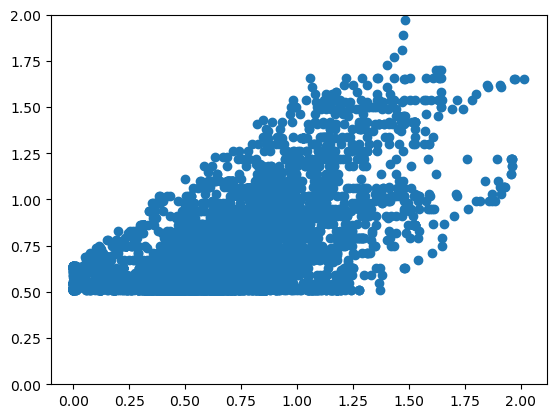

In [76]:
plt.ylim(0, 2.0)
plt.scatter(df_rain_events_for_ml["mrms_qpe"], df_rain_events_for_ml['gauge_qpe']);

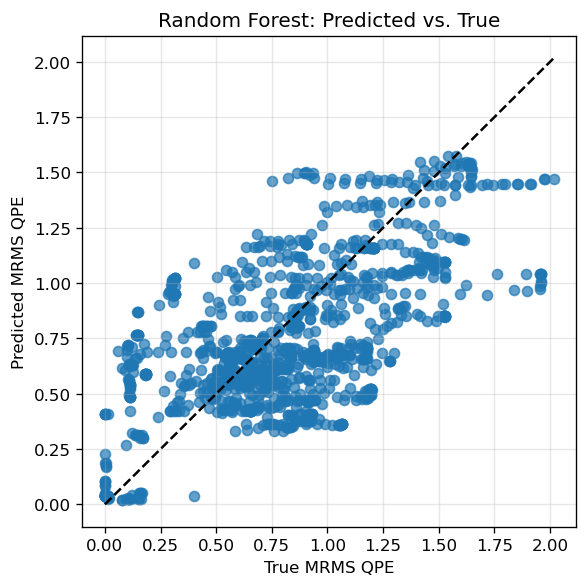

In [77]:
plt.figure(figsize=(5,5), dpi=120)
plt.scatter(y_test, y_pred, alpha=0.7)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'k--', lw=1.5)                 # 1-to-1 reference line
plt.xlabel('True MRMS QPE')
plt.ylabel('Predicted MRMS QPE')
plt.title('Random Forest: Predicted vs. True')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [78]:
from sklearn.inspection import permutation_importance


perm = permutation_importance(
    pipe, X_test, y_test,
    n_repeats=30, random_state=42, n_jobs=-1
)
idx = np.argsort(perm.importances_mean)[::-1]

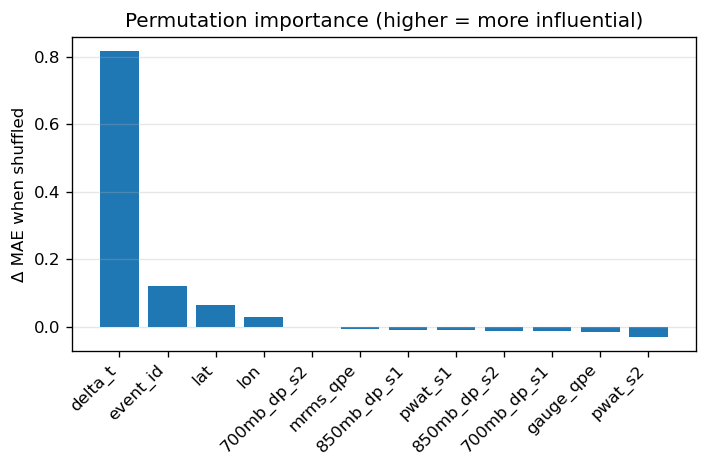

In [79]:
plt.figure(figsize=(6, 4), dpi=120)
plt.bar(range(len(idx)), perm.importances_mean[idx])
plt.xticks(range(len(idx)), [num_cols[i] for i in idx], rotation=45, ha='right')
plt.ylabel('Δ MAE when shuffled')
plt.title('Permutation importance (higher = more influential)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()